In [1]:
import os

# change to the root directory of the project
if os.getcwd().endswith("shap"):
    os.chdir("../src") 

In [2]:
from mlp import MLPDataModule

data = MLPDataModule(neighbor_size=15, val_batch_size=500)
data.setup()

Reading profile data... done
Calculating fill rate for each profile...


  0%|          | 0/69677 [00:00<?, ?it/s]

Building kdtree for each year...


100%|██████████| 61/61 [00:00<00:00, 605.12it/s]


In [3]:
batch = next(iter(data.val_dataloader()))

In [4]:
import numpy as np

dlon = batch[0][:, :, 0].numpy()
dlat = batch[0][:, :, 1].numpy()
print(dlon.mean(), dlon.std(), dlon.min(), dlon.max())
print(dlat.mean(), dlat.std(), dlat.min(), dlat.max())
    

0.10320799999999997 0.7831569289757109 -3.7399999999999984 3.5999999999999996
0.2503466666666668 0.7895521514265046 -3.789999999999992 3.759999999999998


In [5]:
from torch import Tensor
from mlp import InterpMLP


class ShapWrapper(InterpMLP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, input: Tensor) -> Tensor:

        mlp_input = self.mlp_input_layer(input)
        mlp_output = self.mlp_model(mlp_input)

        return mlp_output

In [6]:
from vae import VanillaVAE

vae_model = VanillaVAE.load_from_checkpoint("../logs/VAE/nan_0.7_xyz/checkpoints/last.ckpt") 
vae_model = vae_model.to('cpu') 

model = ShapWrapper.load_from_checkpoint("../logs/MLP/mlp_dlon_dlat/checkpoints/last.ckpt", vae_model=vae_model)
model = model.to('cpu')

In [10]:
from rnn import RNNDataModule
import torch

def get_ith_batch(data: RNNDataModule, i: int):
    for batch in data.val_dataloader():
        if i == 0:
            return batch
        i -= 1
        
def get_shap_input(batch: tuple[torch.Tensor, dict]):
    input, label = batch
    mu, log_var = vae_model.encode(input[:, :, 2:].float())
    encoder_output = vae_model.reparameterize(mu, log_var)
    shap_input = torch.cat([encoder_output, input[:, :, :2].float()], dim=2)
    
    return shap_input

In [8]:
batch0 = get_ith_batch(data, 0)
batch1 = get_ith_batch(data, 1)

In [11]:
import shap

num_samples = 500

backgrounds = get_shap_input(batch0)
explainer = shap.KernelExplainer(model, backgrounds)

shap_input = get_shap_input(batch1)
shap_values = explainer.shap_values(shap_input[:num_samples])

/home/steven/miniconda3/envs/iiot/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [12]:
explanation= shap.Explanation(values=shap_values, data=shap_input[:num_samples])
explanation.shape

(500, 15, 7, 5)

In [ ]:
import shap
shap.initjs()

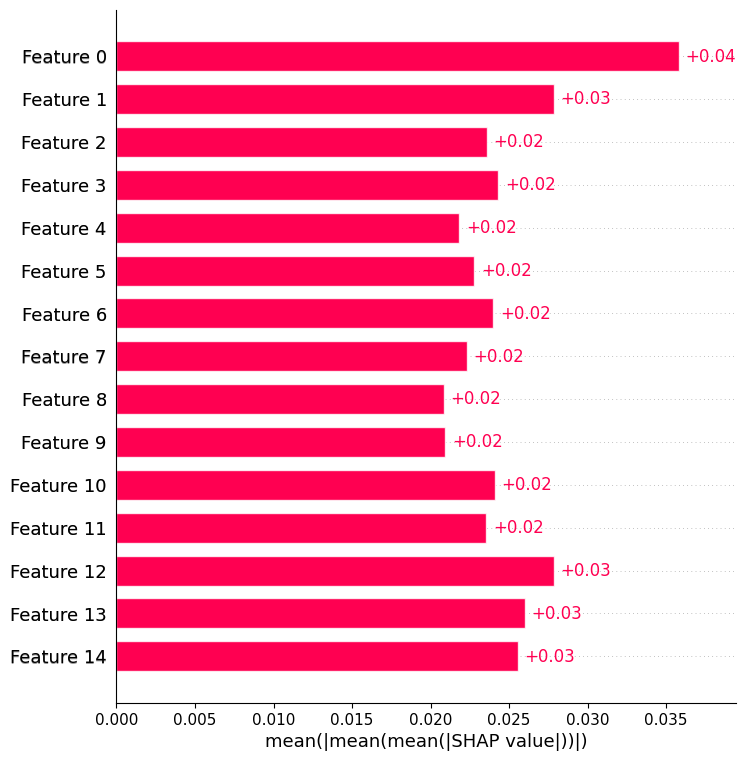

In [20]:
neighbor_explanation = explanation.abs.mean(axis=3).mean(axis=2)

shap.plots.bar(neighbor_explanation, max_display=15, order=range(15))

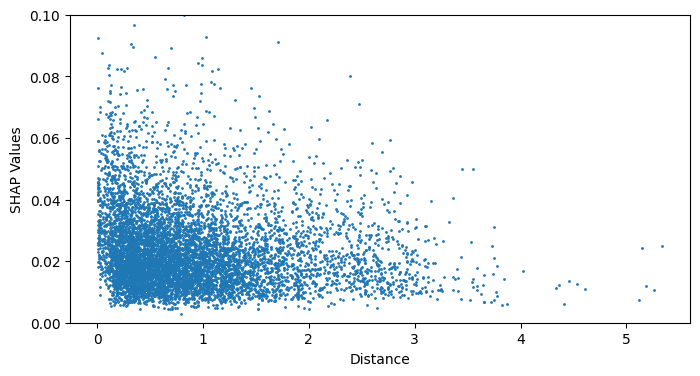

In [17]:
import matplotlib.pyplot as plt
import numpy as np

feat_shap_values = explanation.abs[:, :, :-2].mean(axis=-1).mean(axis=-1)
dis_data = np.sqrt(explanation.data[:, :, -2:].pow(2).sum(axis=-1))

plt.subplots(figsize=(8, 4))

plt.scatter(dis_data.flatten(), feat_shap_values.values.flatten(), s=1)
plt.xlabel("Distance")
plt.ylim(0, 0.1)
plt.ylabel("SHAP Values")

plt.show()

0.9868


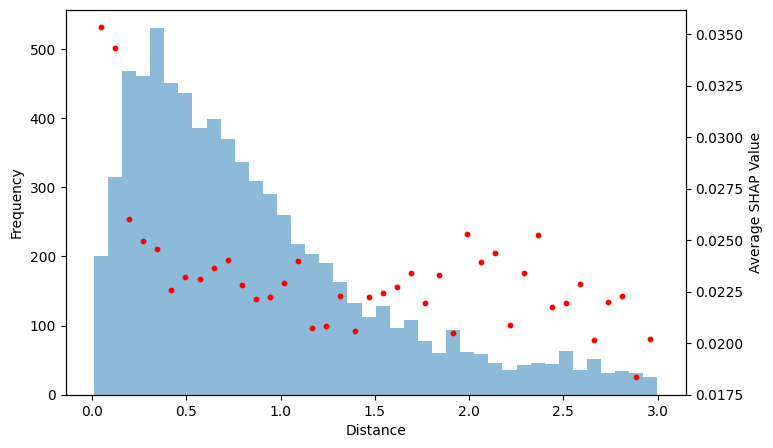

In [21]:
import numpy as np
import matplotlib.pyplot as plt

dis_data = np.sqrt(explanation.data[:, :, -2:].pow(2).sum(axis=-1))
feat_shap_values = explanation.abs[:, :, :-2].mean(axis=-1).mean(axis=-1).values

x = dis_data.flatten()
y = feat_shap_values.flatten()

print(len(x[x < 3]) / len(x))

# 97% of data
y = y[x < 3]
x = x[x < 3]

num_bins = 40
hist, bin_edges = np.histogram(x, bins=num_bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.hist(x, bins=num_bins, alpha=0.5)
ax1.set_xlabel("Distance")
ax1.set_ylabel("Frequency")

ax2 = ax1.twinx()

x_avg = np.zeros(num_bins)
y_avg = np.zeros(num_bins)
for idx, (bin_left, bin_right) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    mask = (x >= bin_left) & (x < bin_right)
    y_avg[idx] = y[mask].mean()
    x_avg[idx] = (bin_left + bin_right) / 2

ax2.scatter(x_avg, y_avg, color="red", s=10)

ax2.set_ylabel("Average SHAP Value")

plt.show()

In [ ]:
print(x[x < 0.005].shape)
print(x.shape)

torch.Size([51663])
torch.Size([52500])
